In [3]:
from pymongo import MongoClient
from bson.son import SON
import pymongo
import pickle
import pandas as pd
import requests
import json
import os
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [4]:

client = MongoClient("localhost", 27017, maxPoolSize=50)
db = client.CovidPoject_db
covidCollection = db["covidProject_data"]
cursor = covidCollection.find({}).limit(1)

df = pd.DataFrame(cursor).set_index(['_id', 'author','title','description','publishedAt','content'])
df


,,,,,,source
_id,author,title,description,publishedAt,content,
61bcfd9c9d874c9af4782aba,Meredith Deliso,'Unprecedented' COVID situation causes city's hospitals to enact crisis standards,"The two largest hospital systems in Albuquerque, New Mexico, have activated crisis standards of care due to an ""unprecedented level"" of activity during the pandemic.",2021-11-11T23:27:26Z,"The two largest hospital systems in Albuquerque, New Mexico, have activated crisis standards of care due to an ""unprecedented level"" of activity during the pandemic, hospital officials announced Thur… [+3027 chars]","{'id': 'abc-news', 'name': 'ABC News'}"


In [5]:
#so this is an overview of the structure of our documents (_id is added by mongodb as an unique key for each document )

In [6]:
covidCollection.count_documents({ })


43229

In this notebook we are going to analyze the main dataset: the articles. To start, we first need to connect to the mongo database where the articles have been inserted. The first think to highlight is that the total number of articles we have in our database is lower than the one we have in the summary recap. This is due to when inserting into the mongo database we check for duplicates. There is a total of 2 897 articles that were duplicates which brings the total articles we have from 46 126 to 43 229.

Let's start by plotting and example of article,check the missing values and then plotting the number of articles over time.

In [7]:
covidCollection.find_one()

{'_id': ObjectId('61bcfd9c9d874c9af4782aba'),
 'source': {'id': 'abc-news', 'name': 'ABC News'},
 'author': 'Meredith Deliso',
 'title': "'Unprecedented' COVID situation causes city's hospitals to enact crisis standards",
 'description': 'The two largest hospital systems in Albuquerque, New Mexico, have activated crisis standards of care due to an "unprecedented level" of activity during the pandemic.',
 'publishedAt': '2021-11-11T23:27:26Z',
 'content': 'The two largest hospital systems in Albuquerque, New Mexico, have activated crisis standards of care due to an "unprecedented level" of activity during the pandemic, hospital officials announced Thur… [+3027 chars]'}

In [8]:
# Let's check if there is missing values

list_missing_values=[]
count =covidCollection.count_documents({'author': None})

count1 =covidCollection.count_documents({'source.id': None})

count2 =covidCollection.count_documents({'source.name': None})

count3 =covidCollection.count_documents({'description': None})

count4 =covidCollection.count_documents({'title': None})

count5 =covidCollection.count_documents({'content': None})

count6 =covidCollection.count_documents({'publishedAt': None})


list_missing_values.append((count,count1,count2,count3,count4,count5,count6))
f1 = pd.DataFrame(list_missing_values, columns=['Author', 'Source.id', 'Source.name','Description','Title','Content','PublishedAt'])
f1

,Author,Source.id,Source.name,Description,Title,Content,PublishedAt
0,6127,0,0,144,2,0,0


So as we can see there is some missing values for these fields : author, description and title but the mongodb is dealing
with those missing values as it assign to this missing values a None value that can be used for the query so we don't 
have to deal with it. For the description it's not a problem as its content is already in the content field. for the title we have just two missing values in 43229 documents so it can be handled too. As for the author we practically don't use it in any of our queries so it's not a problem neither.

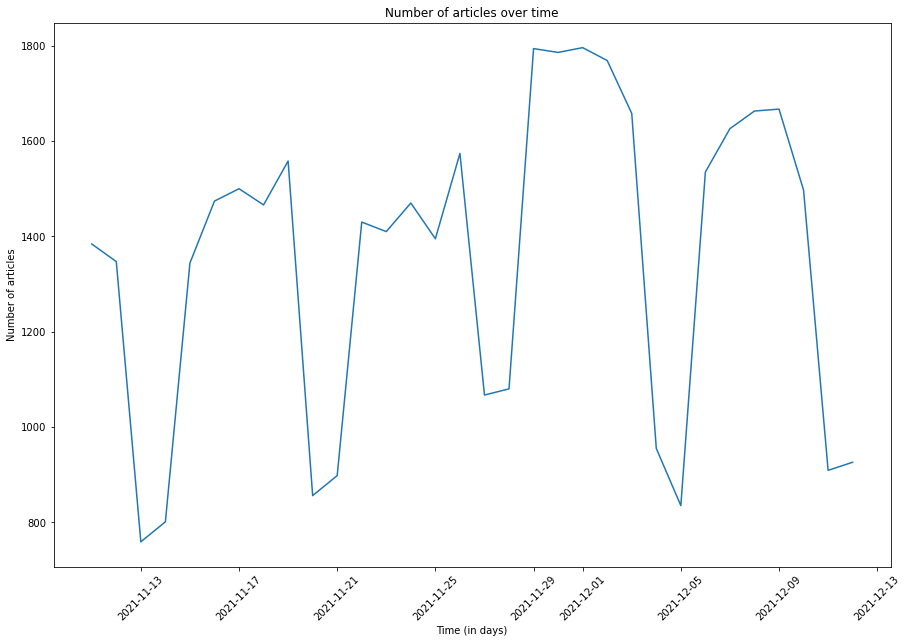

In [9]:
# Start by plotting over time

pipeline = [
    { '$group': {
    '_id': {'$dateToString': { 'date': { '$toDate': '$publishedAt' }, 'format': '%Y-%m-%d' } },
    'count': { '$sum': 1 }
  }},
    {'$sort': SON([('_id', pymongo.ASCENDING)])}
]

res = covidCollection.aggregate(pipeline)

x = []
y = []
for sample in res:
    x.append(datetime.strptime(sample['_id'], '%Y-%m-%d'))
    y.append(sample['count'])
    

plt.plot(x, y)
plt.title("Number of articles over time")
plt.xlabel('Time (in days)')
plt.ylabel('Number of articles')
plt.xticks(rotation = 45)
plt.show()

From the article displayed we can see that several columns could be interesting. The 'source' attribute will allow us to find the articles' category, language and country. Both 'Title' and 'Description' will allow to have a grasp on the article's content. Finally the 'content' attribute could be interesting as it contains the article, however we only have the beginning of the articles (First 1/2 sentences).

Now that we have seen the distribution of the articles over time, let's look at how they are distributed among the categories, the countries and the languages seen in the sources analysis.

In [12]:
# Categories
with open('dictionaries/category_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

results = []
total_articles = covidCollection.count_documents({})
    
for category in loaded_dict.keys():
    count = covidCollection.count_documents({'source.id': {'$in': loaded_dict[category]}})
    percentage = (count / total_articles) * 100
    results.append((category, count, percentage))

df = pd.DataFrame(results, columns=['Category', 'Number of articles', 'Percentage'])
df = df.sort_values(by=['Number of articles'],ascending=False)
df

,Category,Number of articles,Percentage
0,general,37925,87.730459
1,business,3668,8.485045
3,sports,1108,2.563094
2,technology,399,0.922992
4,entertainment,65,0.150362
6,science,48,0.111037
5,health,16,0.037012


Looking at the distribution of articles among the different categories we can see that an overwhelming majority is within the 'general' category, leaving little articles for the rest. The categories 'Entertainment', 'Science' and 'Health' may not be relevant to look at as there is too little values to produce a good analysis.

In [15]:
# Languages
with open('dictionaries/language_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

results = []
total_articles = covidCollection.count_documents({})
    
for category in loaded_dict.keys():
    count = covidCollection.count_documents({'source.id': {'$in': loaded_dict[category]}})
    percentage = (count / total_articles) * 100
    results.append((category, count, percentage))

df = pd.DataFrame(results, columns=['Language', 'Number of articles', 'Percentage'])
df = df.sort_values(by=['Number of articles'],ascending=False)
df

,Language,Number of articles,Percentage
0,en,26778,61.944528
7,es,4256,9.845243
2,it,4138,9.572278
10,ru,2377,5.498624
6,pt,1943,4.494668
5,de,1709,3.953365
8,fr,1461,3.379676
1,no,365,0.844341
11,se,181,0.418700
12,nl,16,0.037012


Same thing happens for the languages, the majority of them are in english, and there are some languages that have not enough or no articles which makes impossible an analysis on them. Between these two groups we have a bunch of languages that could interesting to analyze.

In [17]:
# Countries
with open('dictionaries/country_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

results = []
total_articles = covidCollection.count_documents({})
    
for category in loaded_dict.keys():
    count = covidCollection.count_documents({'source.id': {'$in': loaded_dict[category]}})
    percentage = (count / total_articles) * 100
    results.append((category, count, percentage))

df = pd.DataFrame(results, columns=['Country', 'Number of articles', 'Percentage'])
df = df.sort_values(by=['Number of articles'],ascending=False)
df

,Country,Number of articles,Percentage
0,us,15475,35.797728
3,it,4143,9.583844
6,gb,3393,7.848898
11,ar,3201,7.404751
13,in,2808,6.495640
15,ru,2377,5.498624
8,br,1943,4.494668
7,de,1709,3.953365
9,ca,1590,3.678086
12,fr,1461,3.379676


For the countries we have a little better distribution. Once again we have a first group with the U.S far above the rest. There is a few countries that have a decent amount of articles such as Italia, England, Argentina, India... and that could be intersting to study. Once again we have some contestant with not enough articles such as China, Saudi Arabia, Pakistan, Iceland or the Netherlands.

In [5]:
#now we want to see the occurence of each of this worlds : "vaccine" "omicron"  and for each name of vaccine
#for this we created an index of type TEXT that will concat the content field of all documents so it can be processed as a text 
#and to enable the text search 
from pymongo import TEXT

index_content=covidCollection.create_index([("content", TEXT)], default_language='english')

In [6]:
#check that the index is created
covidCollection.index_information()

{'_id_': {'v': 2, 'key': [('_id', 1)]},
 'content_text': {'v': 2,
  'key': [('_fts', 'text'), ('_ftsx', 1)],
  'weights': SON([('content', 1)]),
  'default_language': 'english',
  'language_override': 'language',
  'textIndexVersion': 3}}

In [7]:
#this two functions will return the occurence of a specific word in the content field of all documents (the index) or if we need 
#to also get the documents then there is the second function search_for_world_sentence that will return the documents that contain the searched word
def occurence_for_world_sentence(search_text):
    count=covidCollection.count_documents({"$text": {"$search": search_text}})
    return  count
def search_for_world_sentence(search_text):
    res=covidCollection.find({"$text": {"$search": search_text}}).limit(10)
    return list(res)
    

As our queries started since 11/11/2021 until 12/12/2021 we locked for the most important things that happened in this period and 
we found out that a new variant with the name of Omicron apperead in 26/11/2021 and there is still a lack of informations
regarding this new variant so we decided to look for the occurence of this word in general during all this period.
Besides, now that the majority of persons took their vaccine for covid19 we wanted to have a look about vaccine preferences 
(moderna, pfizer,janssen,astra).
We considered that word vaccine always refers to vaccine for covid as all of our documents concern covid19

In [226]:
#let's get the occurence of each of the words bellow
list_all=[]
omicron=occurence_for_world_sentence("omicron")
vaccine=occurence_for_world_sentence("vaccine")
moderna=occurence_for_world_sentence("moderna")
pfizer=occurence_for_world_sentence("pfizer")
janssen=occurence_for_world_sentence("janssen")
astra=occurence_for_world_sentence("astrazeneca")
list_all.append((omicron,vaccine,moderna,pfizer,janssen,astra))
f = pd.DataFrame(list_all, columns=['Omicron', 'Vaccine', 'Moderna','Pfizer','Janssen','AstrZeneca'])
f



,Omicron,Vaccine,Moderna,Pfizer,Janssen,AstrZeneca
0,3209,4121,208,633,18,120


Text(0.5, 1.0, 'occurence of each of the three vaccines : pfizer, moderna and janssen')

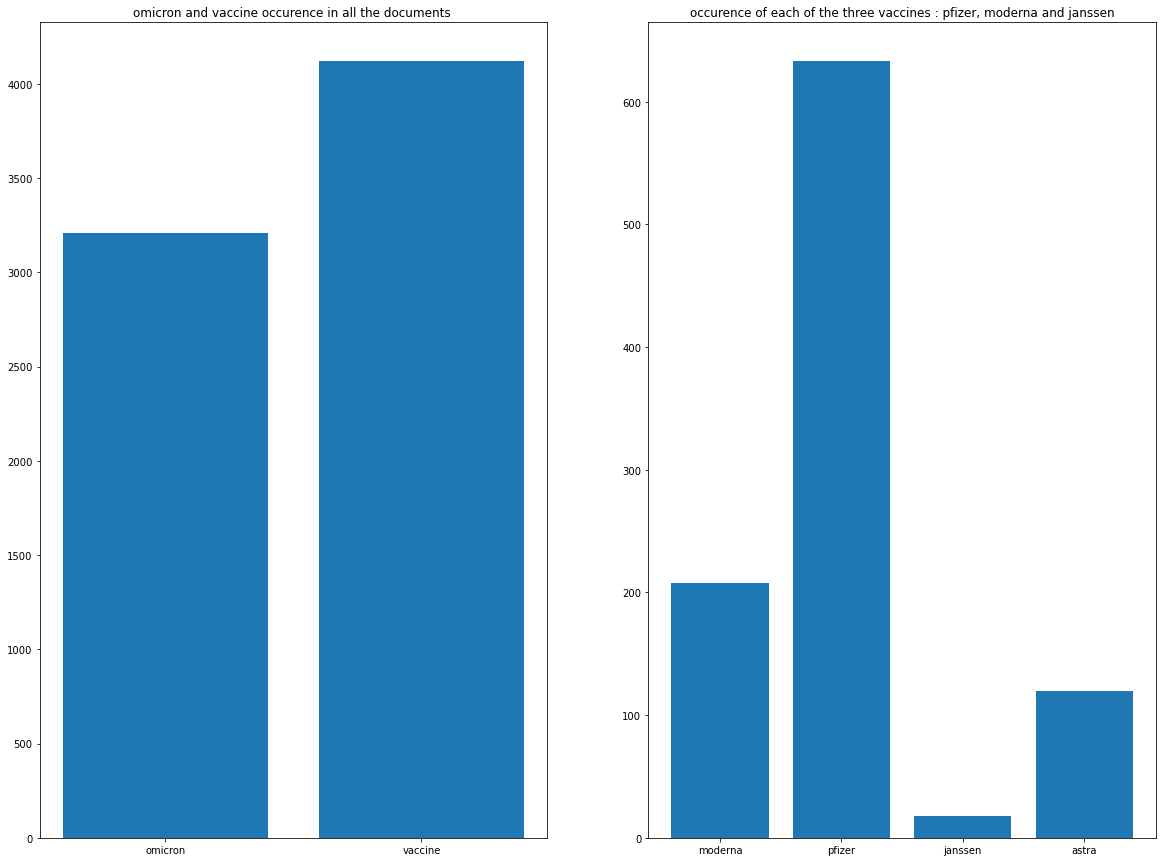

In [225]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))

plt.subplot(131)

names = ['omicron', 'vaccine']
values = [omicron,vaccine]

names2=['moderna','pfizer','janssen','astra'] 
values2 = [moderna,pfizer,janssen,astra]

plt.subplot(121)
plt.bar(names, values)
plt.title('omicron and vaccine occurence in all the documents ')

plt.subplot(122)
plt.bar(names2, values2)
plt.title('occurence of each of the three vaccines : pfizer, moderna and janssen')


* Occurence of the word omicron =3209, not a big number but we have to take in consideration that it can be referred by other 
words like variant for example but for now what we can deduce is that this variant is mentionned  in a lot of articles which 
can mean that people are a bit worried about this variant or that they still trying to figure out more informations about it.
And let's not forget that omicron appeared for the first time on 26/11/2021 so maybe it's beacause we couldn't have enough articles
talking about it as it's more or less in the middle of the period of our queries.

* As for the vaccine we can also take in consideration that it's referred by other words but as we have article talking about the
vaccine so that can help us to know if we can move forward with this word in our analysis or not.

* For the different types of vaccine we can deduce that the most mentionned one is pfizer followed by moderna then astra then janssen
but another time we cannot assume that those are exact values as it can be writed in different ways and the data for the vaccines' type
are not big enough to have a final conclusion of the most preferred vaccine or the most used one. And to have a better idea 
about vaccine types occurence in our documents we did below a pie chart that contains the pourcentage of each one of them
compared to the total :


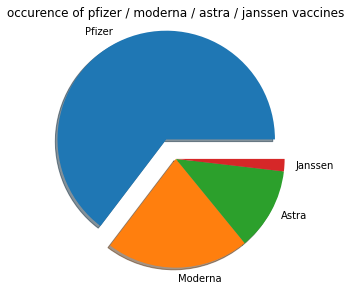

In [231]:

total=moderna+pfizer+janssen+astra
y = np.array([pfizer/total*100,moderna/total*100, astra/total*100, janssen/total*100])
mylabels = [ "Pfizer", "Moderna", "Astra","Janssen"]
myexplode = [0.2, 0, 0, 0]
plt.subplot(111)
plt.pie(y, labels = mylabels, explode = myexplode, shadow = True)
plt.title("occurence of pfizer / moderna / astra / janssen vaccines")
plt.gcf().set_size_inches((14,5))

In [146]:

#now we will go a bit deeper by studing word occurrence for each category 

#this file containt data classified in categories which are (general , science, health, business,technology ,sport , entertainement)
data = pd.read_pickle("category_dict.pkl")

general_list=data['general']
science_list=data['science']
health_list=data['health']
business_list=data['business']
technology_list=data['technology']
sports_list=data['sports']
entertainment_list=data['entertainment']                                                                                
                                  



In [11]:
#!pip install wordcloud
from bs4 import BeautifulSoup
import re
import pymongo
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import string
import seaborn as sns

In [169]:
#we did an aggregation to get only documents with source id in a specific category 

covidData_bodies = []
def aggeregationFunction(array):
    pipelineGeneral = [
            {'$match': 
               { "source.id":{"$in":array}}
            },
            { '$project': 
                { '_id': 0,"content": "$content"}  
            },

        ]
    return pipelineGeneral



docs_general = covidCollection.aggregate(aggeregationFunction(general_list))
docs_general=list(docs_general)

docs_science = covidCollection.aggregate(aggeregationFunction(science_list))
docs_science=list(docs_science)

docs_health = covidCollection.aggregate(aggeregationFunction(health_list))
docs_health=list(docs_health)

docs_business = covidCollection.aggregate(aggeregationFunction(business_list))
docs_business=list(docs_business)

docs_technology = covidCollection.aggregate(aggeregationFunction(technology_list))
docs_technology=list(docs_technology)

docs_sports = covidCollection.aggregate(aggeregationFunction(sports_list))
docs_sports=list(docs_sports)

docs_entertainment = covidCollection.aggregate(aggeregationFunction(entertainment_list))
docs_entertainment=list(docs_entertainment)

#now we have our documents by category

#docs contain all documents with only the three fields: content, publishedAt and source.id as we will need them later
docs=covidCollection.find({},{'content':1,'publishedAt':1,'source.id':1})
docs=list(docs)

  

In [20]:
#!pip install nltk
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

#this function is used to remove the word that we want to ignore 
stop_words = set(stopwords.words('english'))

#as mongodb doesn't allow to have more than one index per collection we tryed another solution to do the keyword search 
#this function will split the given documents into words and store it in list

def filter_entries(entries, stopwords):

    text_entries = BeautifulSoup(str(entries), "lxml").text
    subbed_entries = re.sub('[^A-Za-z0-9]+', ' ', text_entries)
    split_entries = subbed_entries.split()
    
    stop_words = stopwords

    entries_words = []

    for word in split_entries:
       
        if word not in stop_words:
           
            entries_words.append(word)
           
    return entries_words

general_words = filter_entries(docs_general, stop_words)
science_words = filter_entries(docs_science, stop_words)
health_words = filter_entries(docs_health, stop_words)
business_words = filter_entries(docs_business, stop_words)
technology_words = filter_entries(docs_technology, stop_words)
sports_words = filter_entries(docs_sports, stop_words)
entertainment_words = filter_entries(docs_entertainment, stop_words)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
#!pip install translate
import re

import requests
#now we have our function to count the occurence of given list of words
def get_word_counts(words_list , searching_word):
    word_count = {}

    for word in words_list:
        word = word.lower()

        for i in searching_word:
            if re.search( i, word ): 
                if word not in stop_words:
                    if word not in word_count:
                        word_count[word] = 1                                                                
                    else:
                        word_count[word] += 1

    return word_count

In [255]:
list_all_categeoris_data=[]

searching_word_list=[".*covid.*",".*corona.*",".*omicron.*",".*vaccin.*"]
omicron_word_count = get_word_counts(general_words,searching_word_list)
omicron_word_count = Counter(omicron_word_count)
omicron_list =omicron_word_count.most_common(4)
general_omicron_list=omicron_list


searching_word_list=["covid","omicron","vaccin"]
omicron_word_count = get_word_counts(science_words,searching_word_list)
omicron_word_count = Counter(omicron_word_count)
omicron_list =omicron_word_count.most_common(4)
science_omicron_list=omicron_list


searching_word_list=["covid","omicron","vaccin"]
omicron_word_count = get_word_counts(health_words,searching_word_list)
omicron_word_count = Counter(omicron_word_count)
omicron_list =omicron_word_count.most_common(4)
health_omicron_list=omicron_list

searching_word_list=["covid","omicron","vaccin"]
omicron_word_count = get_word_counts(technology_words,searching_word_list)
omicron_word_count = Counter(omicron_word_count)
omicron_list =omicron_word_count.most_common(4)
technology_omicron_list=omicron_list


searching_word_list=["covid","omicron","vaccin"]
omicron_word_count = get_word_counts(business_words,searching_word_list)
omicron_word_count = Counter(omicron_word_count)
omicron_list =omicron_word_count.most_common(6)
business_omicron_list=omicron_list 


searching_word_list=["covid","covid-19","omicron","vaccin"]
omicron_word_count = get_word_counts(entertainment_words,searching_word_list)
omicron_word_count = Counter(omicron_word_count)
omicron_list=omicron_word_count.most_common(4)
entertainement_omicron_list=omicron_list

searching_word_list=["covid", ".*corona.*","omicron","vaccin"]
omicron_word_count = get_word_counts(sports_words,searching_word_list)
omicron_word_count = Counter(omicron_word_count)
omicron_list =omicron_word_count.most_common(4)
sports_omicron_list=omicron_list 
print(general_omicron_list[0])

for j in range (4):
    if j<len(entertainement_omicron_list):
        list_all_categeoris_data.append((general_omicron_list[j],science_omicron_list[j],health_omicron_list[j],technology_omicron_list[j],business_omicron_list[j],entertainement_omicron_list[j],sports_omicron_list[j]))
    else:
         list_all_categeoris_data.append((general_omicron_list[j],science_omicron_list[j],health_omicron_list[j],technology_omicron_list[j],business_omicron_list[j],sports_omicron_list[j]))
 
        
df_categoryValues = pd.DataFrame(list_all_categeoris_data, columns=["General " ,"Science" ,"Health","Technology","Business","Entertainement","Sports" ])
# df = df.sort_values(by=['Occurence of the word vaccine'],ascending=False)
df_categoryValues

for general category :
two
for science category :
for health category :
for technology category :
for business category :
for entertainment category :
for sports category :
('covid', 12008)


,General,Science,Health,Technology,Business,Entertainement,Sports
0,"(covid, 12008)","(covid, 16)","(covid, 8)","(covid, 65)","(covid, 1096)","(covid, 8)","(covid, 84)"
1,"(coronavirus, 5373)","(vaccine, 8)","(vaccine, 1)","(vaccine, 9)","(omicron, 347)","(vaccine, 2)","(vaccination, 6)"
2,"(omicron, 2494)","(omicron, 4)","(vaccination, 1)","(vaccination, 4)","(vaccine, 170)","(vaccinated, 1)","(coronavirus, 5)"
3,"(vaccine, 1597)","(vaccination, 3)","(vaccines, 1)","(omicron, 4)","(vaccines, 81)","(vaccinated, 5)",None


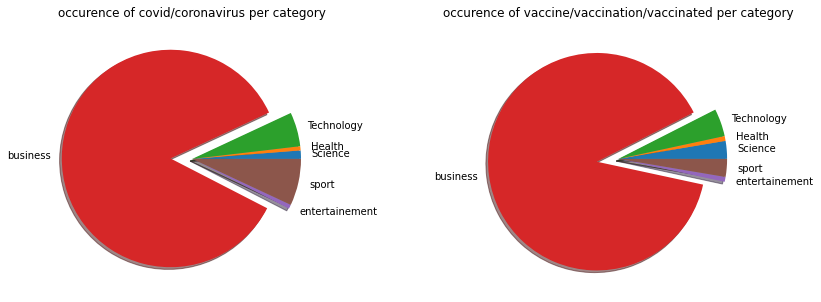

In [23]:
import matplotlib.pyplot as plt
import numpy as np
#covid/corona
total=16+8+65+1096+8+89
y = np.array([16/total*100,8/total*100, 65/total*100, 1096/total*100, 8/total*100 ,89/total*100])
mylabels = [ "Science", "Health", "Technology","business","entertainement","sport"]
myexplode = [0, 0, 0, 0.2,0,0]

plt.subplot(121)
plt.pie(y, labels = mylabels, explode = myexplode, shadow = True)
plt.title("occurence of covid/coronavirus per category")



#vaccine/vaccination/vaccinated
total=11+3+17+369+3+11
y = np.array([11/total*100,3/total*100, 17/total*100, 369/total*100, 3/total*100 ,11/total*100])
mylabels = [ "Science", "Health", "Technology","business","entertainement","sport"]
myexplode = [0, 0, 0, 0.2,0,0]
plt.subplot(122)
plt.pie(y, labels = mylabels, explode = myexplode, shadow = True)
plt.title("occurence of vaccine/vaccination/vaccinated per category")
plt.gcf().set_size_inches((14,5))

when we did a search of word occurence for covid19 and vaccine  by category (we excluded the general category ) as shown in
the chart above, the mojority or articles are from business articles. Even though we have much more business articles than in
other fields, when having a total number of business articles 3668 and the ocurrence of covid and vaccine together =1465 we can 
say that now covid is gaining more attention from financial or business field than health or science  and this is maybe because
that it's secret is revealed (now we have vaccine) so normal people don't pay attention anymore to the virus 
but as it created a new culture ( wearing masks,...) that touch the business field or maybe how the virus accentuate world crisis 
so now it's more like financial damage rather than health damage.

In [256]:
#as we still want to know more about the omicron we will study the occurence of the word omicron per day and see how it will
#evoluate

#this function will return a list of the ocurrence of a given word per day
def getWordperDay(searching_word_list):
    list_date=[]
    list_data=[]
    len(docs)
    for i in range (len(docs)):
        date=docs[i]['publishedAt'].split("T")[0]
   
        if date not in list_date:
             list_date.append(date)
    
    list_data_2 = [0] * len(list_date)
    
    total=0
    for i in docs:
        date=i['publishedAt'].split("T")[0]
        index=list_date.index(date)
        omicron_words = filter_entries(i, stop_words)
        omicron_word_count = get_word_counts(omicron_words,searching_word_list)
        omicron_word_count = Counter(omicron_word_count)
        omicron_list =omicron_word_count.most_common(2)
        if omicron_list:
            #print(index)
            if len(omicron_list)==2:
                total=omicron_list[0][1]+omicron_list[1][1]

                #print(omicron_list[0][1]+omicron_list[1][1])   
            else:
                total=omicron_list[0][1]
                #print(omicron_list[0][1])
            list_data_2[index]+=total
    #print(list_data_2)

    return list_date,list_data_2

In [257]:
#this time we will take in consideration the two words variant and omicron
searching_word_list_or=[".*variant.*",".*omicron.*"]
list1,list2=getWordperDay(searching_word_list_or)

#we will look at the evolution of death wprd per day as well to see the omicron effect on it 
searching_word_list_death=[".*death.*",".*dead.*"]
list_death,list2_death=getWordperDay(searching_word_list_death)


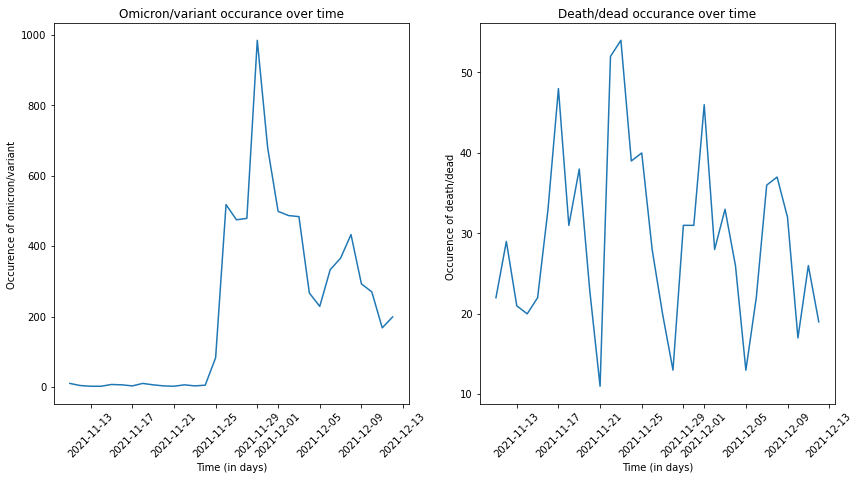

In [119]:
from pandas import read_csv
from matplotlib import pyplot
from datetime import date
# Plot number of articles per day
# Separate X and Y


x = []
y = []
x2=[]
y2=[]
for date, nb_word in zip(list1,list2):

    x.append(datetime.strptime(date, '%Y-%m-%d'))
    y.append(nb_word)

for date, nb_word in zip(list_death,list2_death):

    x2.append(datetime.strptime(date, '%Y-%m-%d'))
    y2.append(nb_word)

plt.subplot(121)
plt.plot(x, y)
plt.title("Omicron/variant occurance over time")
plt.xlabel('Time (in days)')
plt.ylabel('Occurence of omicron/variant ')
plt.xticks(rotation = 45)

plt.subplot(122)
plt.plot(x2, y2)
plt.title("Death/dead occurance over time")
plt.xlabel('Time (in days)')
plt.ylabel('Occurence of death/dead  ')
plt.xticks(rotation = 45)

plt.gcf().set_size_inches((14,7))


as the omicron didn't show up before 26/11/2021 so it's normal that in the first days the ocurrence of omicron is 0 and then 
we see a first peak in the curve around 26/11/2021 and then another bigger peak aroun 29/11/2021 followed by a smaller peak around 08/12/2021 
and then it begins to drop as for the death curve we can see a drop down in around 26/11/2021 - 28/11/2021 and then two other peaks 
but not so important. The number of death/ dead in general is low so it can't provide us precise results but at least we can
say that omicron didn't affect the ocurrence of dead/death and maybe this can explain the drop down in omicron occurence in the
last days 

In [258]:
#as we mentionned the death ocurrence in general let's have a look about the death ocurrence per country 
#the file country_dict.pkl contain the id source of an article together with it's country
data_country = pd.read_pickle("country_dict.pkl")
list_country=[]
list_articles_country=[]
for key in data_country:
    list_country.append(key)
    list_articles_country.append(data_country[key])


In [209]:

#this function will return the ocurrence of each of the given list of words ocurrence per country 
def look_for_word_per_country (searching_word_list):
    list_data_counrty = [0] * len(data_country)
    total=0
    for i in range (len(docs)):
        source=docs[i]['source']['id']
        for key in range (len(list_country)) :
            if source in list_articles_country[key]:
                list_of_words = filter_entries(docs[i]['content'], stop_words)
                
                list_word_count = get_word_counts(list_of_words,searching_word_list)
                list_word_count = Counter(list_word_count)
                list_commun =list_word_count.most_common(2)
                if list_commun:
                 
                    if len(list_commun)==2:
                        total=list_commun[0][1]+list_commun[1][1]
                    else:
                        total=list_commun[0][1]
                list_data_counrty[key]+=total
                break;
    return list_data_counrty 


searching_word_list_=[".*death.*",".*dead.*"]   
list_per_country_death=look_for_word_per_country (searching_word_list_)
result=[] 
for i in range (len(list_country)):
    result.append((list_country[i],list_per_country_death[i]))
       
        
columns = ['Country'] + ['Occurence of the word death/dead']
df = pd.DataFrame(result, columns=columns)
df = df.sort_values(by=['Occurence of the word death/dead'],ascending=False)
df




,Country,Occurence of the word death/dead
0,us,17089
3,it,4429
6,gb,3775
11,ar,3701
13,in,3524
15,ru,2727
8,br,2184
7,de,1849
12,fr,1722
9,ca,1704


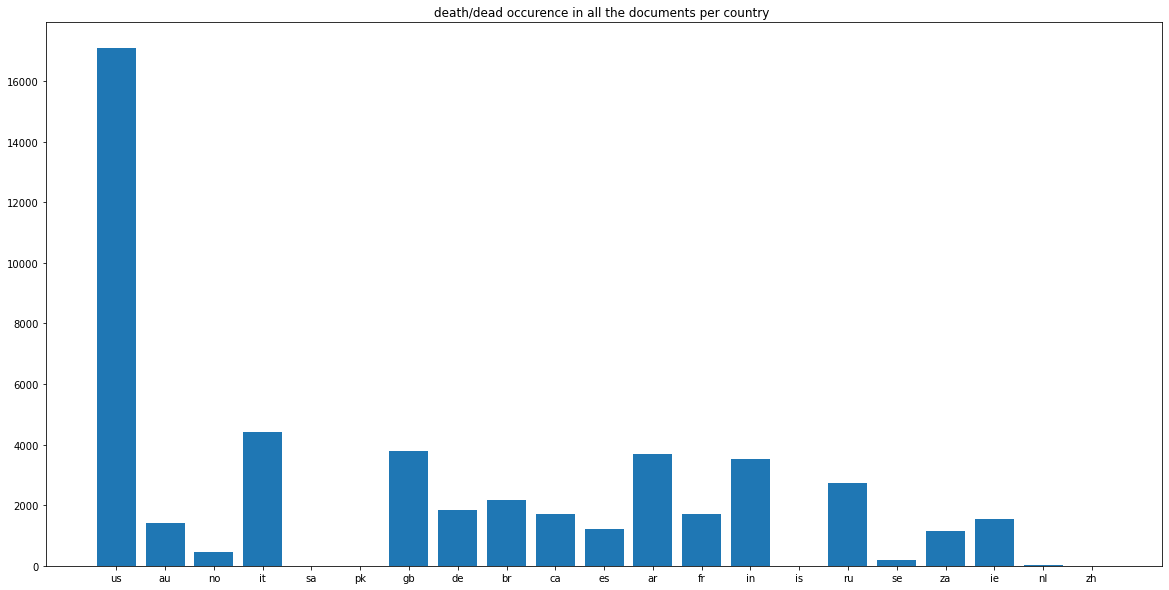

In [210]:
plt.figure(figsize=(20, 15))

plt.subplot(131)

names = list_country

values = list_per_country_death


plt.subplot(111)
plt.bar(names, values)
plt.title('death/dead occurence in all the documents per country ')
plt.gcf().set_size_inches((20,10))

In [ ]:
The US is ranked first having the higher death ocurrence followed by Italy and then Great Britan but it's not suprising when 
those three have also the hogher number of articles (US: 15475, IT:4143,GB:3393) but when we compare the number of articles
with the occurence of each of these countries it can be considerate as a high number and maybe it also differ from one country
to another depending on the population or  on the disponibility of the vaccine or other resources so what we can do now is to look for the ocurrence
of vaccine in each country

In [211]:
#let's take a look now at the ocurrence of the word vaccine per country 

searching_word_list_vaccine=[".*vaccin.*"]   
list_per_country_vaccine=look_for_word_per_country (searching_word_list_vaccine)
result_vaccine=[] 
for i in range (len(list_country)):
    result_vaccine.append((list_country[i],list_per_country_vaccine[i]))
       
        
columns = ['Country'] + ['Occurence of the word vaccine']
df = pd.DataFrame(result_vaccine, columns=columns)
df = df.sort_values(by=['Occurence of the word vaccine'],ascending=False)
df

,Country,Occurence of the word vaccine
0,us,17701
3,it,4692
6,gb,3732
11,ar,3601
13,in,3563
15,ru,2800
7,de,2121
8,br,2075
9,ca,1900
18,ie,1764


the ocurrence of vaccine per country is very proportional to the one for the death so it can't provide us with further informations

Now that we have seen the distribution of articles among the different group we have and that we studied the words we looked for, Let's see more generally  and  look within those which are the more recurrent words so maybe we can discover new things that we didn't take in consideration.

In [20]:
# Code to find more recurrent words.

from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize

import nltk
from nltk.corpus import stopwords

stopwords_dict = {
    'en': 'english',
    'it': 'italian',
    'es': 'spanish',
    'fr': 'french',
    'pt': 'portuguese',
    'ru': 'russian',
    'de': 'german',
    'no': 'norwegian',
    'se': 'swedish',
    'nl': 'dutch',
}

def get_counter_from_query(query, attribute, lang='all'):
    my_counter = Counter()
    
    for obj in covidCollection.find(query):
        if obj[attribute]:
            # Tokenize and give it to the counter
            tokens = word_tokenize(obj[attribute].lower())
            my_counter.update(tokens)
    
    # remove stop words
    if lang == 'all':
        for stopword_lang in stopwords_dict.keys():
            stops = set(stopwords.words(stopwords_dict[stopword_lang]))
            for word in stops:
                if word in my_counter:
                    del my_counter[word]
    else:
        stopword_lang = lang
        
        stops = set(stopwords.words(stopwords_dict[stopword_lang]))
        for word in stops:
            if word in my_counter:
                del my_counter[word]
    
    # Remove items under size 2 chars
    del_list =['...', '+++']
    for key in my_counter:
        if len(key) <= 2:
            del_list.append(key)

    for item in del_list:
        del my_counter[item]
    
    return my_counter

Let's start by looking at the title attribute with all the articles.

In [21]:
number_most_common = 10
att = 'title'
count = get_counter_from_query({}, att)

print(count.most_common(number_most_common))

[('covid', 6822), ('covid-19', 5388), ('coronavirus', 3644), ('omicron', 3036), ('casos', 3014), ('argentina', 2544), ('new', 2505), ('reuters', 2298), ('vaccine', 1849), ('noviembre', 1828)]


As expected, the words appearing the most are Covid and Covid-19. We can note that the first 3 words are used to call the virus. Finally the 4th word appearing the most is Omicron which is the new covid variant that appeared the 26th of Novembre (So in the middle of dataset in terms of dates). The fifth word is cases in spanish which probably tells that there is a high number of articles that speaks about covid cases. The word 'new' can be both associated to the new variant as well as new cases so it does not bring much information. Finally the word 'Argentina' comes in 7th position appearing 2544 times while there is only 3201 articles coming from Argentina which mean that they probably mention their country in most of the title. Then comes 'Reuters' an international news organization present in the sources that has 2473 articles in the dataset and that signs them with name which explains the presents of 'reuters' in this list. Then comes 'vaccines' which is a very common article theme and finally 'Noviembre' which is november in spanish as most of the articles we have in the dataset are published in the previous month: November.

In [22]:
number_most_common = 10
att = 'description'
count = get_counter_from_query({}, att)

print(count.most_common(number_most_common))

[('covid-19', 8883), ('new', 4797), ('said', 3246), ('variant', 3240), ('covid', 3225), ('omicron', 2921), ('número', 2870), ('fallecidos', 2786), ('actuales', 2784), ('repaso', 2779)]


In [23]:
number_most_common = 10
att = 'content'
count = get_counter_from_query({}, att)

print(count.most_common(number_most_common))

[('chars', 40620), ('covid-19', 11509), ('coronavirus', 6195), ('new', 5805), ('pandemia', 3329), ('covid', 3271), ('variant', 3264), ('said', 3126), ('omicron', 3033), ('país', 2885)]


Now looking at the most recurrent work in both 'description' and 'content' attribute we can see that we find again 'covid' and 'covid-19' to name the virus, then we have a theme around Omicron the new variant with 'Omicron', 'variant', 'new'. Regarding the description we can see that we have the word 'fallecidos' which means deads in spanish which hints at articles indicating the number of new cases and death per country/ in the world as there as been since the pandemia started.

In [25]:
# Reccurence of words by languages over the title attribute
with open('dictionaries/language_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

results = []
number_most_common = 10
att = 'title'

languages = ['en', 'es', 'it', 'fr', 'de', 'ru', 'pt']
    
for lang in languages:
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[lang]}}, att, lang)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (lang, ) + tuple_words
    
    results.append(row)
    
columns = ['Language'] + ['#' + str(x+1) for x in range(number_most_common)]
df = pd.DataFrame(results, columns=columns)
df

,Language,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,en,"(covid, 4042)","(covid-19, 3859)","(omicron, 2722)","(new, 2414)","(reuters, 2297)","(vaccine, 1772)","(variant, 1628)","(says, 1612)","(cases, 1396)","(biden, 1164)"
1,es,"(coronavirus, 2910)","(casos, 2896)","(argentina, 2524)","(noviembre, 1814)","(diciembre, 1070)","(buenos, 723)","(aires, 723)","(san, 443)","(cuántos, 433)","(registran, 357)"
2,it,"(covid, 2101)","(casi, 495)","(nuovi, 456)","(positivi, 275)","(contagi, 241)","(morti, 236)","(vaccini, 226)","(pass, 195)","(decessi, 191)","(green, 181)"
3,fr,"(covid-19, 286)","(covid, 143)","(contre, 94)","(foot, 91)","(omicron, 86)","(france, 78)","(variant, 72)","(plus, 65)","(face, 52)","(crise, 49)"
4,de,"(corona-news, 130)","(aktuell, 118)","(inzidenz, 110)","(deutschland, 109)","(corona, 107)","(corona-pandemie, 85)","(omikron, 77)","(impfpflicht, 74)","(mehr, 73)","(news, 70)"
5,ru,"(covid-19, 653)","(рбк, 223)","(россии, 215)","(covid, 204)","(коронавируса, 180)","(омикрон-штамма, 108)","(que, 104)","(for, 89)","(из-за, 85)","(por, 83)"
6,pt,"(covid-19, 387)","(contra, 200)","(diz, 173)","(rio, 165)","(ômicron, 150)","(variante, 140)","(vacina, 131)","(campinas, 129)","(covid, 121)","(nova, 115)"


In [26]:
# Reccurence of words by languages over the description attribute
results = []
att = 'description'
for lang in languages:
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[lang]}}, att, lang)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (lang, ) + tuple_words
    
    results.append(row)
    
columns = ['Language'] + ['#' + str(x+1) for x in range(number_most_common)]
df_description = pd.DataFrame(results, columns=columns)
df_description

,Language,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,en,"(covid-19, 6233)","(new, 4572)","(said, 3166)","(variant, 3055)","(omicron, 2613)","(health, 2280)","(coronavirus, 2266)","(cases, 2031)","(vaccine, 1755)","(covid, 1672)"
1,es,"(número, 2795)","(fallecidos, 2786)","(actuales, 2781)","(repaso, 2779)","(enfermos, 2779)","(curados, 2779)","(salud, 2677)","(según, 2674)","(ministerio, 2662)","(datos, 2659)"
2,it,"(ansa, 2238)","(covid, 1077)","(casi, 678)","(nuovi, 608)","(tamponi, 461)","(positivi, 444)","(ieri, 393)","(ore, 353)","(contagi, 348)","(oggi, 334)"
3,fr,"(plus, 220)","(covid-19, 201)","(contre, 139)","(depuis, 113)","(après, 109)","(france, 106)","(sanitaire, 104)","(covid, 103)","(pays, 101)","(monde, 100)"
4,de,"(deutschland, 195)","(neue, 152)","(mehr, 148)","(überblick, 136)","(neuinfektionen, 126)","(rki, 124)","(inzidenz, 123)","(meldet, 96)","(corona-news, 93)","(viele, 91)"
5,ru,"(the, 1206)","(covid-19, 983)","(full, 556)","(read, 554)","(article, 554)","(rt.com, 554)","(/li, 516)","(коронавируса, 472)","(россии, 456)","(has, 343)"
6,pt,"(covid-19, 602)","(leia, 507)","(nesta, 384)","(the, 328)","(post, 319)","(contra, 306)","(rio, 303)","(appeared, 253)","(saúde, 252)","(first, 241)"


In [27]:
# Reccurence of words by languages over the content attribute
results = []
att = 'content'
for lang in languages:
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[lang]}}, att, lang)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (lang, ) + tuple_words
    
    results.append(row)
    
columns = ['Language'] + ['#' + str(x+1) for x in range(number_most_common)]
df_content = pd.DataFrame(results, columns=columns)
df_content

,Language,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,en,"(chars, 25791)","(covid-19, 7553)","(new, 5590)","(variant, 3104)","(said, 3028)","(omicron, 2751)","(coronavirus, 2728)","(health, 2529)","(cases, 2189)","(reuters, 2053)"
1,es,"(chars, 4255)","(coronavirus, 2998)","(pandemia, 2921)","(año, 2848)","(medida, 2789)","(lleva, 2784)","(argentina, 2749)","(distritos, 2722)","(país, 2696)","(contagios, 2677)"
2,it,"(chars, 3959)","(ansa, 2149)","(nov, 1323)","(covid, 1163)","(dic, 829)","(casi, 700)","(nuovi, 693)","(tamponi, 539)","(roma, 460)","(positivi, 454)"
3,fr,"(chars, 1460)","(covid-19, 277)","(novembre, 247)","(2021., 202)","(plus, 193)","(après, 151)","(contre, 147)","(france, 146)","(afp, 143)","(monde, 138)"
4,de,"(chars, 1709)","(deutschland, 263)","(and, 182)","(mehr, 176)","(rki, 125)","(neue, 123)","(coronavirus, 117)","(the, 110)","(personal, 108)","(neuen, 105)"
5,ru,"(covid-19, 2231)","(the, 1431)","(chars, 1001)","(qr-, 522)","(and, 337)","(that, 216)","(que, 203)","(del, 176)","(2021, 156)","(for, 152)"
6,pt,"(chars, 1888)","(covid-19, 598)","(nesta, 447)","(contra, 308)","(rio, 285)","(paulo, 245)","(saúde, 221)","(variante, 190)","(brasil, 166)","(pandemia, 164)"


Now if we look this time separating by language, we can see some words that overlap and that we already seen when doing so with all the articles, such as 'covid-19' which comes amongst the top 10 in 5 languages. Word such as 'cases', 'morti' as well as names of places 'argentina', 'buenos aires', 'россии' (translate to Russia) hits again at articles talking about the number of new infections and death in the world. We also see a high number of apparition that talk about the new variant Omicron. We can also see some word talking about vaccination policies and sanitary pass in some languages such as italian ('pass') or french ('sanitaire'). We can also see a small aparition as the 10th most used word in english for 'biden' the US president.

In [29]:
# Reccurence of words by country over the title attribute
with open('dictionaries/country_dict.pkl') as f:
    loaded_dict = pickle.load(f)

results = []
number_most_common = 10
att = 'title'

countries = ['us', 'it', 'gb', 'ar', 'in', 'de', 'ca', 'fr']
    
for country in countries:
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[country]}}, att)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (country, ) + tuple_words
    
    results.append(row)
    
columns = ['Country'] + ['#' + str(x+1) for x in range(number_most_common)]
df = pd.DataFrame(results, columns=columns)
df

,Country,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,us,"(reuters, 2297)","(covid, 1993)","(covid-19, 1928)","(omicron, 1583)","(vaccine, 1187)","(new, 1186)","(biden, 1037)","(variant, 947)","(says, 893)","(cases, 548)"
1,it,"(covid, 2103)","(casi, 495)","(nuovi, 456)","(positivi, 275)","(contagi, 241)","(morti, 236)","(vaccini, 226)","(pass, 195)","(decessi, 191)","(green, 181)"
2,gb,"(covid, 901)","(omicron, 396)","(new, 341)","(covid-19, 253)","(says, 228)","(variant, 217)","(vaccine, 176)","(christmas, 175)","(cases, 158)","(travel, 116)"
3,ar,"(casos, 2888)","(coronavirus, 2886)","(argentina, 2522)","(noviembre, 1812)","(diciembre, 1064)","(buenos, 723)","(aires, 723)","(san, 439)","(cuántos, 432)","(registran, 357)"
4,in,"(covid, 526)","(india, 474)","(covid-19, 404)","(omicron, 367)","(new, 279)","(cases, 251)","(variant, 207)","(says, 166)","(vaccine, 153)","(govt, 121)"
5,de,"(corona-news, 130)","(aktuell, 118)","(inzidenz, 110)","(deutschland, 109)","(corona, 107)","(corona-pandemie, 85)","(omikron, 77)","(impfpflicht, 74)","(mehr, 73)","(news, 70)"
6,ca,"(covid-19, 615)","(new, 244)","(cases, 187)","(canada, 114)","(need, 106)","(says, 103)","(vaccine, 102)","(know, 101)","(ottawa, 98)","(alberta, 98)"
7,fr,"(covid-19, 286)","(covid, 143)","(contre, 94)","(foot, 91)","(omicron, 86)","(france, 78)","(variant, 72)","(plus, 65)","(face, 52)","(crise, 49)"


In [30]:
# Reccurence of words by country over the description attribute
results = []
att = 'description'
for country in countries:
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[country]}}, att)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (country, ) + tuple_words
    
    results.append(row)
    
columns = ['Country'] + ['#' + str(x+1) for x in range(number_most_common)]
df_description = pd.DataFrame(results, columns=columns)
df_description

,Country,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,us,"(covid-19, 3768)","(new, 2650)","(said, 2068)","(variant, 1886)","(omicron, 1597)","(coronavirus, 1564)","(biden, 1135)","(vaccine, 1131)","(health, 1090)","(u.s., 1084)"
1,it,"(ansa, 2238)","(covid, 1077)","(casi, 678)","(nuovi, 608)","(tamponi, 461)","(positivi, 444)","(ieri, 393)","(ore, 353)","(contagi, 348)","(oggi, 334)"
2,gb,"(new, 415)","(says, 342)","(variant, 314)","(coronavirus, 294)","(covid-19, 284)","(covid, 270)","(said, 248)","(omicron, 241)","(people, 225)","(health, 207)"
3,ar,"(fallecidos, 2783)","(número, 2782)","(repaso, 2779)","(enfermos, 2779)","(actuales, 2779)","(curados, 2779)","(salud, 2658)","(según, 2652)","(ministerio, 2651)","(datos, 2650)"
4,in,"(india, 786)","(covid-19, 778)","(said, 633)","(new, 625)","(variant, 424)","(cases, 423)","(omicron, 403)","(health, 360)","(covid, 337)","(news, 327)"
5,de,"(deutschland, 195)","(neue, 152)","(mehr, 148)","(überblick, 136)","(neuinfektionen, 126)","(rki, 124)","(inzidenz, 123)","(meldet, 96)","(corona-news, 93)","(viele, 91)"
6,ca,"(covid-19, 713)","(new, 405)","(health, 328)","(cases, 292)","(/li, 268)","(pandemic, 183)","(canada, 167)","(says, 153)","(vaccine, 150)","(variant, 149)"
7,fr,"(plus, 220)","(covid-19, 201)","(contre, 139)","(depuis, 113)","(après, 109)","(france, 106)","(sanitaire, 104)","(covid, 103)","(pays, 101)","(monde, 100)"


In [31]:
# Reccurence of words by languages over the content attribute
results = []
att = 'content'
for country in countries:
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[country]}}, att)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (country, ) + tuple_words
    
    results.append(row)
    
columns = ['Country'] + ['#' + str(x+1) for x in range(number_most_common)]
df_content = pd.DataFrame(results, columns=columns)
df_content

,Country,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,us,"(chars, 15122)","(covid-19, 4131)","(new, 3093)","(reuters, 2044)","(coronavirus, 1836)","(variant, 1667)","(said, 1555)","(omicron, 1399)","(u.s., 1282)","(president, 1278)"
1,it,"(chars, 3964)","(ansa, 2149)","(nov, 1323)","(covid, 1163)","(dic, 829)","(casi, 700)","(nuovi, 693)","(tamponi, 539)","(roma, 460)","(positivi, 454)"
2,gb,"(chars, 3356)","(image, 749)","(new, 676)","(covid-19, 639)","(said, 572)","(variant, 508)","(covid, 507)","(coronavirus, 468)","(omicron, 460)","(caption, 416)"
3,ar,"(chars, 3201)","(coronavirus, 2931)","(pandemia, 2872)","(año, 2798)","(medida, 2784)","(lleva, 2780)","(argentina, 2745)","(distritos, 2722)","(país, 2669)","(contagios, 2660)"
4,in,"(chars, 2239)","(covid-19, 847)","(india, 847)","(/li, 670)","(news, 607)","(new, 598)","(covid, 514)","(omicron, 477)","(variant, 441)","(said, 406)"
5,de,"(chars, 1709)","(deutschland, 263)","(mehr, 176)","(rki, 125)","(neue, 123)","(coronavirus, 117)","(personal, 108)","(neuen, 105)","(robert, 99)","(zahl, 94)"
6,ca,"(chars, 1590)","(covid-19, 688)","(new, 489)","(cases, 393)","(health, 341)","(first, 204)","(people, 170)","(province, 167)","(reported, 165)","(says, 149)"
7,fr,"(chars, 1460)","(covid-19, 277)","(novembre, 247)","(2021., 202)","(plus, 193)","(après, 151)","(contre, 147)","(france, 146)","(afp, 143)","(monde, 138)"


The results separating by country are quite similar to the ones by languages. This is very understandable as those two separation overlap. The major change is the apparititon of several english speaking country, from a single row to several with 'us', 'gb'(England), 'in'(India), 'ca'(Canada) but the most repeated words are quite similar and doesn't bring any new information.

In [33]:
# Reccurence of words by country over the title attribute
with open('dictionaries/category_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

results = []
number_most_common = 10
att = 'title'
    
for category in loaded_dict.keys():
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[category]}}, att)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (category, ) + tuple_words
    
    results.append(row)
    
columns = ['Category'] + ['#' + str(x+1) for x in range(number_most_common)]
df = pd.DataFrame(results, columns=columns)
df

,Category,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,general,"(covid, 6218)","(covid-19, 4864)","(coronavirus, 3515)","(casos, 3002)","(omicron, 2633)","(argentina, 2542)","(reuters, 2298)","(new, 2265)","(noviembre, 1827)","(vaccine, 1666)"
1,business,"(covid, 475)","(omicron, 367)","(covid-19, 340)","(bloomberg, 215)","(says, 208)","(variant, 187)","(new, 174)","(vaccine, 155)","(aktuell, 115)","(corona-news, 110)"
2,technology,"(techcrunch, 49)","(raises, 44)","(new, 24)","(platform, 19)","(covid, 19)","(apple, 18)","(startup, 17)","(business, 16)","(series, 16)","(2021, 14)"
3,sports,"(covid-19, 132)","(covid, 101)","(foot, 91)","(stimulus, 70)","(check, 62)","(vs., 52)","(tax, 48)","(nba, 47)","(2022, 44)","(coronavirus, 39)"
4,entertainment,"(covid-19, 6)","(2021, 6)","(covid, 5)","(review, 4)","(new, 4)","(best, 4)","(fecha, 3)","(sony, 3)","(netflix, 3)","(halo, 3)"
5,health,"(covid-19, 13)","(risk, 4)","(may, 3)","(vaccine, 3)","(inflammation, 2)","(could, 2)","(severe, 2)","(common, 2)","(death, 2)","(months, 2)"
6,science,"(covid-19, 28)","(news, 16)","(omicron, 12)","(vaccine, 6)","(could, 4)","(risk, 4)","(covid, 4)","(variant, 4)","(booster, 3)","(likely, 3)"


In [34]:
# Reccurence of words by country over the description attribute
results = []
att = 'description'
for category in loaded_dict.keys():
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[category]}}, att)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (category, ) + tuple_words
    
    results.append(row)
    
columns = ['Category'] + ['#' + str(x+1) for x in range(number_most_common)]
df_description = pd.DataFrame(results, columns=columns)
df_description

,Category,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,general,"(covid-19, 8038)","(new, 4289)","(said, 2964)","(covid, 2907)","(variant, 2883)","(número, 2859)","(fallecidos, 2785)","(actuales, 2783)","(repaso, 2779)","(enfermos, 2779)"
1,business,"(covid-19, 577)","(omicron, 348)","(new, 338)","(post, 337)","(first, 334)","(variant, 322)","(said, 258)","(appeared, 254)","(covid, 250)","(infomoney, 213)"
2,technology,"(new, 50)","(million, 48)","(company, 44)","(announced, 32)","(startup, 32)","(today, 31)","(raised, 28)","(covid-19, 27)","(world, 26)","(people, 25)"
3,sports,"(apos, 204)","(covid-19, 200)","(new, 83)","(stimulus, 60)","(covid, 58)","(2021, 56)","(states, 55)","(game, 54)","(latest, 52)","(/li, 52)"
4,entertainment,"(entire, 12)","(post, 11)","(new, 9)","(one, 7)","(series, 7)","(xbox, 6)","(movie, 6)","(game, 6)","(time, 5)","(watch, 5)"
5,health,"(covid-19, 13)","(new, 7)","(study, 6)","(people, 4)","(severe, 4)","(recent, 4)","(whether, 3)","(research, 3)","(help, 3)","(concludes, 3)"
6,science,"(coronavirus, 42)","(news, 33)","(latest, 32)","(covid-19, 25)","(new, 21)","(cases, 18)","(updated, 16)","(every, 16)","(day, 16)","(including, 16)"


In [35]:
# Reccurence of words by languages over the content attribute
results = []
att = 'content'
for category in loaded_dict.keys():
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[category]}}, att)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (category, ) + tuple_words
    
    results.append(row)
    
columns = ['Category'] + ['#' + str(x+1) for x in range(number_most_common)]
df_content = pd.DataFrame(results, columns=columns)
df_content

,Category,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,general,"(chars, 35378)","(covid-19, 10437)","(coronavirus, 5814)","(new, 5145)","(pandemia, 3278)","(covid, 2934)","(variant, 2876)","(país, 2868)","(año, 2862)","(said, 2850)"
1,business,"(chars, 3633)","(covid-19, 776)","(new, 516)","(variant, 362)","(omicron, 347)","(coronavirus, 335)","(covid, 260)","(said, 249)","(u.s., 232)","(lettura, 195)"
2,technology,"(chars, 395)","(new, 51)","(million, 50)","(covid-19, 45)","(company, 38)","(today, 37)","(posters, 36)","(world, 35)","(participating, 34)","(enlarge/, 32)"
3,sports,"(chars, 1085)","(covid-19, 226)","(images, 81)","(stimulus, 80)","(new, 79)","(states, 74)","(united, 66)","(game, 62)","(covid, 62)","(2021, 58)"
4,entertainment,"(chars, 65)","(like, 9)","(one, 7)","(new, 7)","(getty, 6)","(images, 6)","(many, 6)","(series, 6)","(2022, 5)","(halo, 5)"
5,health,"(chars, 16)","(/li, 14)","(study, 7)","(covid-19, 6)","(researchers, 5)","(sars-cov-2, 5)","(found, 4)","(patients, 4)","(health, 4)","(whether, 3)"
6,science,"(chars, 48)","(clare, 23)","(wilson, 23)","(michael, 22)","(page, 22)","(wong, 18)","(adam, 18)","(vaughan, 18)","(graham, 17)","(lawton, 17)"


Looking now separating by category we can see that the general category results are really similar to when looking all categories together, mostly due to the fact that the majority of articles provides from general newspapers. However looking at smaller categories some things stands out. The 'business' category doesn't stand out from the 'general' one as they are similar/identical words. For the 'technology' category we have word like 'company', 'startup', 'apple', 'business' meaning that in this category the articles tend to talk about companies. In sports we have words like 'foot', 'stimulus check', 'nba', 'game' which is quite comprehensible as those articles probably talk about the effect of covid on sport. Finally for the last categories, as said earlier, there are very little articles which makes this analysis not that usefull. However even with that problem, the 'health' and 'sience' categories shows that they use some words related to the medical and scientific world such as 'inflamation', 'research', 'risk'...